### Google Colab Setup

we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section. Run the following cell to mount your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below.

In [3]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 'Test' folder and put all the files under 'example' folder, then 'Test/example'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Test/example'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', 'for_knn.py']


Once you have successfully mounted your Google Drive and located the path to this tutorial, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello World!
```

In [4]:
import for_knn as utils
utils.hello()

Hello world!


# K-Nearest Neighbors

> referenced by EECS498

In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

The K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

We can break the process down into two steps:

1. Compute the (squared Euclidean) distances between all training examples and all test examples
2. Given these distances, for each test example find its k nearest neighbors and have them vote for the label to output

In [5]:
import torch

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [6]:
class KnnClassifier:
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def compute_distances(self, x_test):
        num_train = self.x_train.shape[0]
        num_test = x_test.shape[0]
        dists = self.x_train.new_zeros(num_train, num_test)

        # 각 훈련 샘플과 테스트 샘플 사이의 거리 계산
        ##### naive version
        # for i in range(num_train):
        #     for j in range(num_test):
        #         dists[i, j] = ((self.x_train[i] - x_test[j]) ** 2).sum().sqrt()

        ##### vectorization
        A = self.x_train.reshape(num_train,-1)
        B = x_test.reshape(num_test,-1)
        AB2 = A.mm(B.T)*2
        dists = ((A**2).sum(dim = 1).reshape(-1,1) - AB2 + (B**2).sum(dim = 1).reshape(1,-1))**(1/2)

        return dists

    def predict_labels(self, dists, k=1):
        num_train, num_test = dists.shape
        y_pred = torch.zeros(num_test, dtype=torch.int64)

        # 가장 가까운 k개의 이웃의 인덱스 계산
        top_k = torch.topk(dists, k, 0, False).indices

        # 각 테스트 샘플에 대해 예측
        for j in range(num_test):
            # 가장 가까운 k개 이웃의 라벨을 가져와서 가장 많은 라벨로 예측
            y_pred[j] = self.y_train[top_k[:, j]].bincount().argmax()

        return y_pred

    def predict(self, x_test, k=1):

        dists = self.compute_distances(x_test)
        y_test_pred = self.predict_labels(dists, k=k)
        return y_test_pred

    def check_accuracy(self, x_test, y_test, k=1, quiet=False):

        y_test_pred = self.predict(x_test, k=k)
        num_samples = x_test.shape[0]
        num_correct = (y_test == y_test_pred).sum().item()
        accuracy = 100.0 * num_correct / num_samples
        msg = (
            f"Got {num_correct} / {num_samples} correct; "
            f"accuracy is {accuracy:.2f}%"
        )

        if not quiet:
          print(msg)

        return accuracy


# Run Code!
## Data preprocessing / Visualization

When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

In [7]:
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = utils.cifar10(num_train, num_test)

print("Training set:")
print(f"data.shape : {x_train.shape}")
print(f"labels shape : {y_train.shape}")

print("\nTest set:")
print(f"data.shape : {x_test.shape}")
print(f"labels shape : {y_test.shape}")

100%|██████████| 170498071/170498071 [00:02<00:00, 74723081.86it/s]


Extracting ./cifar-10-python.tar.gz to .
Training set:
data.shape : torch.Size([5000, 3, 32, 32])
labels shape : torch.Size([5000])

Test set:
data.shape : torch.Size([500, 3, 32, 32])
labels shape : torch.Size([500])


To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

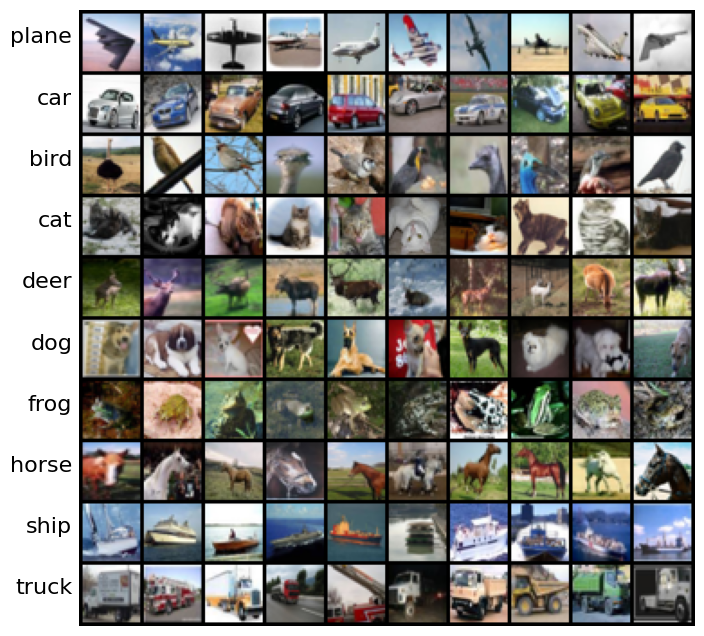

In [8]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 10

utils.visualize_dataset(x_train, y_train, samples_per_class, classes)

## Cross-validation

Now let's integrate everything and evaluate our K-NN classifier on CIFAR-10. However, **how do we determine the optimal value of k?**, **Which k yields the best performance?**

We will use **cross-validation** to set this hyperparameter in a more principled manner. we can use the results of cross-validation to select the best value for k, and rerun the classifier on our training examples.


In [9]:
def knn_cross_validate(x_train, y_train, num_folds=5, k_choices=[1, 3, 5, 8, 10, 12, 15, 20, 50, 100],):

    x_train_folds = []
    y_train_folds = []

    x_train_folds = torch.chunk(x_train, num_folds)
    y_train_folds = torch.chunk(y_train, num_folds)

    k_to_accuracies = {}

    for k in k_choices:
      k_to_accuracies[k] = []
      for n in range(num_folds):
        # 검증 데이터를 제외한 나머지 데이터로 학습 데이터 생성
        x_train_list = x_train_folds[:n] + x_train_folds[n+1:]
        y_train_list = y_train_folds[:n] + y_train_folds[n+1:]

        # 검증 데이터 생성
        x_test, y_test = x_train_folds[n], y_train_folds[n]
        x_train, y_train = torch.cat(x_train_list), torch.cat(y_train_list)

        knn_classifer = KnnClassifier(x_train, y_train)
        accuracy = knn_classifer.check_accuracy(x_test, y_test, k, True)

        k_to_accuracies[k].append(accuracy)

    func = lambda k: sum(k_to_accuracies[k])/num_folds
    best_k = max(k_to_accuracies, key=func)

    return k_to_accuracies, best_k

In [10]:
k_to_accuracies, best_k = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
  print('k = %d got accuracies: %r' % (k, accs))

k = 1 got accuracies: [26.3, 25.7, 26.4, 27.8, 26.6]
k = 3 got accuracies: [23.9, 24.9, 24.0, 26.6, 25.4]
k = 5 got accuracies: [24.8, 26.6, 28.0, 29.2, 28.0]
k = 8 got accuracies: [26.2, 28.2, 27.3, 29.0, 27.3]
k = 10 got accuracies: [26.5, 29.6, 27.6, 28.4, 28.0]
k = 12 got accuracies: [26.0, 29.5, 27.9, 28.3, 28.0]
k = 15 got accuracies: [25.2, 28.9, 27.8, 28.2, 27.4]
k = 20 got accuracies: [27.0, 27.9, 27.9, 28.2, 28.5]
k = 50 got accuracies: [27.1, 28.8, 27.8, 26.9, 26.6]
k = 100 got accuracies: [25.6, 27.0, 26.3, 25.6, 26.3]


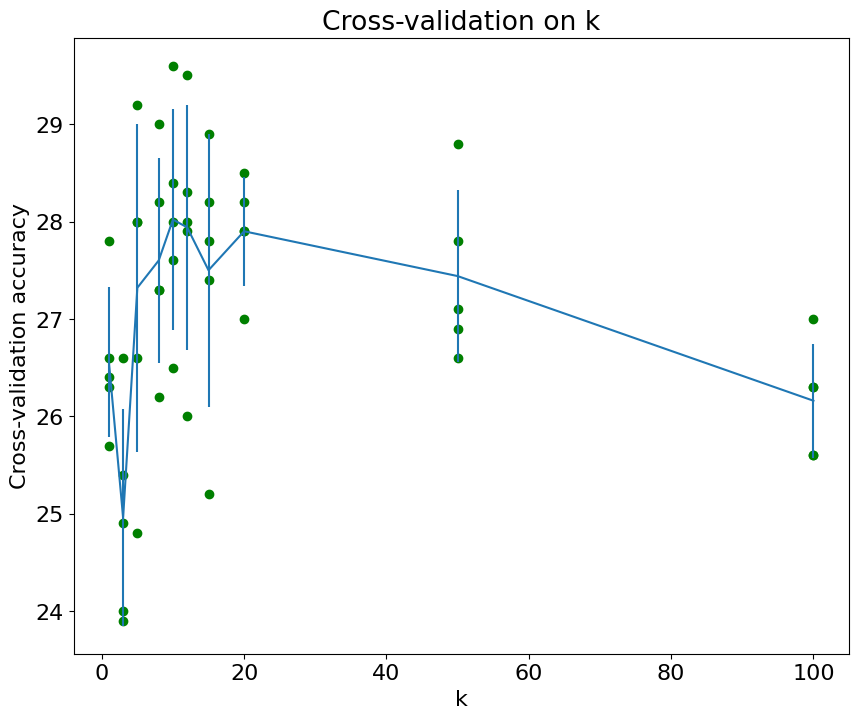

In [11]:
utils.visualize_cross_validation(k_to_accuracies)

Now we can use the results of cross-validation to select the best value for k, and rerun the classifier on our full 5000 set of training examples.

When we compare k=1 with the best k value, we notice a considerable increase in accuracy!"

In [12]:
classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=1)

Got 137 / 500 correct; accuracy is 27.40%


27.4

In [13]:
classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=best_k)

Got 141 / 500 correct; accuracy is 28.20%


28.2

Finally, we can use our chosen value of k to run on the entire training and test sets.

In [15]:
x_train_all, y_train_all, x_test_all, y_test_all = utils.cifar10()

classifier = KnnClassifier(x_train_all, y_train_all)
classifier.check_accuracy(x_test_all, y_test_all, k=best_k)

Got 3386 / 10000 correct; accuracy is 33.86%


33.86